# CIFAR-10: Part 2

Welcome back! If you have not completed [Part 1](*), please do so before running the code in this notebook. 

In Part 2 we will assume you have the training and testing lmdbs, as well as the trained model .pb files from Part 1. As you may recall from Part 1, we created the dataset in the form of lmdbs then trained a model and saved the trained model in the form of a *predict_net.pb* and an *init_net.pb*. In this notebook, we will show how to test that saved model with the test lmdb and how to continue training to increase our test accuracy.

Recall the objectives of the two part CIFAR-10 tutorial:

**Part 1:**
- Download dataset
- Write images to lmdbs
- Define and train a model with checkpoints
- Save the trained model

**Part 2:**
- Load pre-trained model from Part 1
- Run inference on testing lmdb
- Continue training to improve test accuracy
- Test the retrained model

As before, let's start with some necessary imports.

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
import numpy as np
import os
import shutil
import operator
import glob
from caffe2.python import core,model_helper,optimizer,workspace,brew,utils
from caffe2.proto import caffe2_pb2
import matplotlib.pyplot as plt 
from caffe2.python.modeling import initializers
from caffe2.python.modeling.parameter_info import ParameterTags

## Check Inputs

Before we get started, let's make sure you have the necessary Part 1 files. We will use the saved model from the most recent run of Part 1.

In [2]:
# Train lmdb
TRAIN_LMDB = os.path.join(os.path.expanduser('~'),"caffe2_notebooks/tutorial_data/cifar10/training_lmdb")
# Test lmdb
TEST_LMDB = os.path.join(os.path.expanduser('~'),"caffe2_notebooks/tutorial_data/cifar10/testing_lmdb")


# Extract protobuf files from most recent Part 1 run
part1_runs_path = os.path.join(os.path.expanduser('~'), "caffe2_notebooks", "tutorial_files", "tutorial_cifar10")
runs = sorted(glob.glob(part1_runs_path + "/*"))

# Init net
INIT_NET = os.path.join(runs[-1], "cifar10_init_net.pb")
# Predict net
PREDICT_NET = os.path.join(runs[-1], "cifar10_predict_net.pb")


# Make sure they all exist
if (not os.path.exists(TRAIN_LMDB)) or (not os.path.exists(TEST_LMDB)) or (not os.path.exists(INIT_NET)) or (not os.path.exists(PREDICT_NET)):
    print("ERROR: input not found!")
else:
    print("Success, you may continue!")

Success, you may continue!


### Repeat Helper Functions

If these functions look familiar, you are correct; they have been copied-and-pasted from Part 1. To summarize, we will need the *AddInputLayer* function to connect our models to the lmdbs, and the *Add_Original_CIFAR10_Model* function to provide the architecture of the network.

In [3]:
def AddInputLayer(model, batch_size, db, db_type):
    # load the data
    #data_uint8, label = brew.db_input(
    #    model,
    #   blobs_out=["data_uint8", "label"],
    #   batch_size=batch_size,
    #   db=db,
    #    db_type=db_type,
    #)
    data_uint8, label = model.TensorProtosDBInput([], ["data_uint8", "label"], batch_size=batch_size, db=db, db_type=db_type)
    # cast the data to float
    data = model.Cast(data_uint8, "data", to=core.DataType.FLOAT)
    # scale data from [0,255] down to [0,1]
    data = model.Scale(data, data, scale=float(1./256))
    # don't need the gradient for the backward pass
    data = model.StopGradient(data, data)
    return data, label

def update_dims(height, width, kernel, stride, pad):
    new_height = ((height - kernel + 2*pad)//stride) + 1
    new_width = ((width - kernel + 2*pad)//stride) + 1
    return new_height, new_width

def Add_Original_CIFAR10_Model(model, data, num_classes, image_height, image_width, image_channels):
    # Convolutional layer 1
    conv1 = brew.conv(model, data, 'conv1', dim_in=image_channels, dim_out=32, kernel=5, stride=1, pad=2)
    h,w = update_dims(height=image_height, width=image_width, kernel=5, stride=1, pad=2)
    # Pooling layer 1
    pool1 = brew.max_pool(model, conv1, 'pool1', kernel=3, stride=2)
    h,w = update_dims(height=h, width=w, kernel=3, stride=2, pad=0)
    # ReLU layer 1
    relu1 = brew.relu(model, pool1, 'relu1')
    
    # Convolutional layer 2
    conv2 = brew.conv(model, relu1, 'conv2', dim_in=32, dim_out=32, kernel=5, stride=1, pad=2)
    h,w = update_dims(height=h, width=w, kernel=5, stride=1, pad=2)
    # ReLU layer 2
    relu2 = brew.relu(model, conv2, 'relu2')
    # Pooling layer 1
    pool2 = brew.average_pool(model, relu2, 'pool2', kernel=3, stride=2)
    h,w = update_dims(height=h, width=w, kernel=3, stride=2, pad=0)
    
    # Convolutional layer 3
    conv3 = brew.conv(model, pool2, 'conv3', dim_in=32, dim_out=64, kernel=5, stride=1, pad=2)
    h,w = update_dims(height=h, width=w, kernel=5, stride=1, pad=2)
    # ReLU layer 3
    relu3 = brew.relu(model, conv3, 'relu3')
    # Pooling layer 3
    pool3 = brew.average_pool(model, relu3, 'pool3', kernel=3, stride=2)
    h,w = update_dims(height=h, width=w, kernel=3, stride=2, pad=0)
    
    # Fully connected layers
    fc1 = brew.fc(model, pool3, 'fc1', dim_in=64*h*w, dim_out=64)
    fc2 = brew.fc(model, fc1, 'fc2', dim_in=64, dim_out=num_classes)
    
    # Softmax layer
    softmax = brew.softmax(model, fc2, 'softmax')
    return softmax

## Test Saved Model From Part 1

### Construct Model for Testing

The first thing we need is a model helper object that we can attach the lmdb reader to.

In [4]:
# Create a ModelHelper object with init_params=False
arg_scope = {"order": "NCHW"}
test_model = model_helper.ModelHelper(name="test_model", arg_scope=arg_scope, init_params=False)

# Add the data input layer to the model, pointing at the TEST_LMDB
data,_ = AddInputLayer(test_model,1,TEST_LMDB,'lmdb')

### Populate the Model Helper with Saved Model Params

To format a model for testing, we do not need to create params in the model helper, nor do we need to add gradient operators as we will only be performing forward passes. All we really need to do is populate the *.net* and *.param_init_net* members of the model helper with the contents of the saved *predict_net.pb* and *init_net.pb*, respectively. To accomplish this, we construct *caffe2_pb* objects with the protobuf from the pb files, create *Net* objects with the *caffe2_pb* objects, then **append** the net objects to the *.net* and *.param_init_net* members of the model helper. Appending is very important here! If we do not append, we would wipe out the input data layer stuff that we just added.

Recall from Part 1, the saved model expected an input named *data* and produced an output called *softmax*. Conveniently (but not accidentally), the *AddInputLayer* function reads from the lmdb and puts the information into the workspace in a blob called *data*. It is also important to remember what each of the saved nets that we are appending to our model contains. The *predict_net* contains the structure of the model, including the ops involved in the forward pass. It has the definitions of the convolutional, pooling, and fc layers in the model. The *init_net* contains the weight initializations for the parameters that the ops in the *predict_net* expect. For example, if there is an op in the *predict_net* named 'fc1', the *init_net* will contain the trained weights (*fc1_w*), and biases (*fc1_b*) for that layer. 

After we append the nets, we add an accuracy layer to the model which uses the *softmax* output from the saved model and the *label* input from the lmdb. Note, we could manually fetch the softmax blob from the workspace after every iteration and check whether or not the class with the highest softmax score is the true label, but instead we opt for the simpler accuacy layer. 

In [5]:
# Populate the model helper obj with the init net stuff, which provides the 
#    weight initializations for the model
init_net_proto = caffe2_pb2.NetDef()
with open(INIT_NET, "r") as f:
    init_net_proto.ParseFromString(f.read())
test_model.param_init_net = test_model.param_init_net.AppendNet(core.Net(init_net_proto))

# Populate the model helper obj with the predict net stuff, which defines 
#    the structure of the model
predict_net_proto = caffe2_pb2.NetDef()
with open(PREDICT_NET, "r") as f:
    predict_net_proto.ParseFromString(f.read())
test_model.net = test_model.net.AppendNet(core.Net(predict_net_proto))

# Add an accuracy feature to the model for convenient reporting during testing
accuracy = brew.accuracy(test_model, ['softmax', 'label' ], 'accuracy')

### Run Testing

At this point, our model is initialized as the saved model from Part 1. We can now run the testing loop and check the accuracy.

In [6]:
# Run the param init net to put the trained model info into the workspace
workspace.RunNetOnce(test_model.param_init_net)
workspace.CreateNet(test_model.net, overwrite=True)

# Stat keeper
avg_accuracy = 0.0

# Number of test iterations to run here, since the full test set is 10k images and the
#  batch size is 1, we will run 10000 test batches to cover the entire test set
test_iters = 10000

# Main testing loop
for i in range(test_iters):
    workspace.RunNet(test_model.net)
    acc = workspace.FetchBlob('accuracy')
    avg_accuracy += acc
    if (i % 500 == 0) and (i > 0):
        print("Iter: {}, Current Accuracy: {}".format(i, avg_accuracy/float(i)))

# Report final test accuracy score as the number of correct predictions divided by 10,000
print("*********************************************")
print("Final Test Accuracy: ",avg_accuracy/float(test_iters))

Iter: 500, Current Accuracy: 0.654
Iter: 1000, Current Accuracy: 0.663
Iter: 1500, Current Accuracy: 0.640666666667
Iter: 2000, Current Accuracy: 0.643
Iter: 2500, Current Accuracy: 0.6356
Iter: 3000, Current Accuracy: 0.639333333333
Iter: 3500, Current Accuracy: 0.639142857143
Iter: 4000, Current Accuracy: 0.63625
Iter: 4500, Current Accuracy: 0.636444444444
Iter: 5000, Current Accuracy: 0.6352
Iter: 5500, Current Accuracy: 0.638181818182
Iter: 6000, Current Accuracy: 0.638666666667
Iter: 6500, Current Accuracy: 0.638461538462
Iter: 7000, Current Accuracy: 0.636428571429
Iter: 7500, Current Accuracy: 0.634533333333
Iter: 8000, Current Accuracy: 0.63475
Iter: 8500, Current Accuracy: 0.633058823529
Iter: 9000, Current Accuracy: 0.632111111111
Iter: 9500, Current Accuracy: 0.632421052632
*********************************************
Final Test Accuracy:  0.6321


## Continue Training

Our model is performing significantly better than random guessing, but I think we can do a little better with more training. To do this we will:
- create a new model helper
- specify that the train data will come from the training lmdb
- re-define the model architecture with the Add_Original_CIFAR10_Model function
- grab the trained weights and biases from the saved init_net.pb
- resume training

### Construct Model for Re-Training

Here we create a new model helper object for training. Nothing here should look new but take notice that we set **init_params=False**. This is important, as we do not want brew (in *Add_Original_CIFAR10_Model* function) to automatically initialize the params, rather we want to set them ourselves. Once we construct the model helper, we add the input layer and point it to the training lmdb, brew in the model architecture, and finally initialize the parameters by appending the contents of the saved *init_net.pb* to the *.param_init_net* member of the train model.

In [7]:
# Number of iterations to train for here
training_iters = 3000

# Reset workspace to clear all of the information from the testing stage
workspace.ResetWorkspace()

# Create new model
arg_scope = {"order": "NCHW"}
train_model = model_helper.ModelHelper(name="cifar10_train", arg_scope=arg_scope, init_params=False)

# Add the data layer to the model
data,_ = AddInputLayer(train_model,100,TRAIN_LMDB,'lmdb')
softmax = Add_Original_CIFAR10_Model(train_model, data, 10, 32, 32, 3)

# Populate the param_init_net of the model obj with the contents of the init net
init_net_proto = caffe2_pb2.NetDef()
with open(INIT_NET, "r") as f:
    init_net_proto.ParseFromString(f.read())
tmp_init_net = core.Net(init_net_proto)
train_model.param_init_net = train_model.param_init_net.AppendNet(tmp_init_net)

### Specify Loss Function and Optimizer

We can now proceed as normal by specifying the loss function, adding the gradient operators, and building the optimizier. Here, we opt for the same loss function and optimizer that we used in Part 1.

In [8]:
# Add the "training operators" to the model
xent = train_model.LabelCrossEntropy([softmax, 'label'], 'xent')
# compute the expected loss
loss = train_model.AveragedLoss(xent, "loss")
# track the accuracy of the model
accuracy = brew.accuracy(train_model, [softmax, 'label'], "accuracy")
# use the average loss we just computed to add gradient operators to the model
train_model.AddGradientOperators([loss])
# Specify Optimization Algorithm
optimizer.build_sgd(
    train_model,
    base_learning_rate=0.01,
    policy="fixed",
    momentum=0.9,
    weight_decay=0.004
)

**Important Note**

Check out the results of the *GetOptimizationParamInfo* function. The *params* that this function returns are the parameters that will be optimized by the optimization function. If you are attempting to retrain a model in a different way, and your model doesnt seem to be learning, check the return value of this fuction. If it returns nothing, look no further for your problem! This is exactly the reason that we brew'ed in the layers of the train model with the *Add_Original_CIFAR10_Model* function, because it creates the params in the model automatically. If we had appended the *.net* member of the Model Helper as we did for the test model, this function would return nothing, meaning no parameters would get optimized. A workaround if you appended the net would be to manually create the params with the *create_param* function, which feels like a bit of a hack, especially if you have the add model code on-hand. 

In [9]:
for param in train_model.GetOptimizationParamInfo():
    print("Param to be optimized: ",param)

Param to be optimized:  conv3_b
Param to be optimized:  fc2_w
Param to be optimized:  fc1_b
Param to be optimized:  conv1_b
Param to be optimized:  conv2_b
Param to be optimized:  conv3_w
Param to be optimized:  fc2_b
Param to be optimized:  fc1_w
Param to be optimized:  conv2_w
Param to be optimized:  conv1_w


### Run Training

**This step will take a while!**

With our model helper setup we can now run the training as normal. Note, the accuracy and loss reported here is as measured on the *training* batches. Recall that the accuracy reported in Part 1 was the validation accuracy. Be careful how you interpret this number!

In [10]:
# Prime the workspace
workspace.RunNetOnce(train_model.param_init_net)
workspace.CreateNet(train_model.net, overwrite=True)

# Run the training loop
for i in range(training_iters):
    workspace.RunNet(train_model.net)
    acc = workspace.FetchBlob('accuracy')
    loss = workspace.FetchBlob('loss')
    if i % 100 == 0:
        print ("Iter: {}, Loss: {}, Accuracy: {}".format(i,loss,acc))

Iter: 0, Loss: 1.02017736435, Accuracy: 0.629999995232
Iter: 100, Loss: 1.03627979755, Accuracy: 0.639999985695
Iter: 200, Loss: 1.01044285297, Accuracy: 0.649999976158
Iter: 300, Loss: 1.11098098755, Accuracy: 0.569999992847
Iter: 400, Loss: 0.857563138008, Accuracy: 0.660000026226
Iter: 500, Loss: 0.947329521179, Accuracy: 0.689999997616
Iter: 600, Loss: 1.03314650059, Accuracy: 0.660000026226
Iter: 700, Loss: 0.916410207748, Accuracy: 0.72000002861
Iter: 800, Loss: 0.780662596226, Accuracy: 0.730000019073
Iter: 900, Loss: 0.84335398674, Accuracy: 0.709999978542
Iter: 1000, Loss: 0.813905596733, Accuracy: 0.740000009537
Iter: 1100, Loss: 0.696036875248, Accuracy: 0.730000019073
Iter: 1200, Loss: 0.901836633682, Accuracy: 0.680000007153
Iter: 1300, Loss: 0.892839670181, Accuracy: 0.649999976158
Iter: 1400, Loss: 0.832642018795, Accuracy: 0.72000002861
Iter: 1500, Loss: 0.771974146366, Accuracy: 0.72000002861
Iter: 1600, Loss: 0.926190078259, Accuracy: 0.699999988079
Iter: 1700, Loss: 

## Test the Retrained Model

We will test the retrained model, just as we did in the first part of this notebook. However, since the params already exist in the workspace from the retraining step, we do not need to set the *.param_init_net*. Rather, we set **init_params=False** and brew in the model architecture with *Add_Original_CIFAR10_Model*. When we create the net, the model will find that the required blobs are already in the workspace. Then, we can run the main testing loop, which will report a final test accuracy score (which is hopefully higher).

In [11]:
arg_scope = {"order": "NCHW"}
# Construct the model
test_model = model_helper.ModelHelper(name="test_model", arg_scope=arg_scope, init_params=False)
# Set the input as the test lmdb
data,_ = AddInputLayer(test_model,1,TEST_LMDB,'lmdb')
# brew in the model architecture
softmax = Add_Original_CIFAR10_Model(test_model, data, 10, 32, 32, 3)
accuracy = brew.accuracy(test_model, ['softmax', 'label' ], 'accuracy')
# Prime the net
workspace.RunNetOnce(test_model.param_init_net)
workspace.CreateNet(test_model.net, overwrite=True)

# Confusion Matrix for CIFAR-10
cmat = np.zeros((10,10))

# Stat keepers
avg_accuracy = 0.0
test_iters = 10000

# Main testing loop
for i in range(test_iters):
    workspace.RunNet(test_model.net)
    acc = workspace.FetchBlob('accuracy')
    avg_accuracy += acc
    if (i % 500 == 0) and (i > 0):
        print("Iter: {}, Current Accuracy: {}".format(i, avg_accuracy/float(i)))
        
    # Get the top-1 prediction
    results = workspace.FetchBlob('softmax')[0]
    label = workspace.FetchBlob('label')[0]
    max_index, max_value = max(enumerate(results), key=operator.itemgetter(1))    
    # Update confusion matrix
    cmat[label,max_index] += 1

# Report final testing results
print("*********************************************")
print("Final Test Accuracy: ",avg_accuracy/float(test_iters))


Iter: 500, Current Accuracy: 0.712
Iter: 1000, Current Accuracy: 0.721
Iter: 1500, Current Accuracy: 0.718
Iter: 2000, Current Accuracy: 0.713
Iter: 2500, Current Accuracy: 0.71
Iter: 3000, Current Accuracy: 0.716
Iter: 3500, Current Accuracy: 0.72
Iter: 4000, Current Accuracy: 0.71675
Iter: 4500, Current Accuracy: 0.719555555556
Iter: 5000, Current Accuracy: 0.7194
Iter: 5500, Current Accuracy: 0.720363636364
Iter: 6000, Current Accuracy: 0.721166666667
Iter: 6500, Current Accuracy: 0.720461538462
Iter: 7000, Current Accuracy: 0.719571428571
Iter: 7500, Current Accuracy: 0.7188
Iter: 8000, Current Accuracy: 0.7185
Iter: 8500, Current Accuracy: 0.718235294118
Iter: 9000, Current Accuracy: 0.718
Iter: 9500, Current Accuracy: 0.717157894737
*********************************************
Final Test Accuracy:  0.7169


### Check Results

Notice, the result from testing the re-trained model is better than the original test accuracy. If you wish, you can save the new model as .pb files just as in Part 1, but we will leave that to you. The last thing we will do is attempt to visualize the performance of our classifier by plotting a confusion matrix and looking for a **strong diagonal** trend.

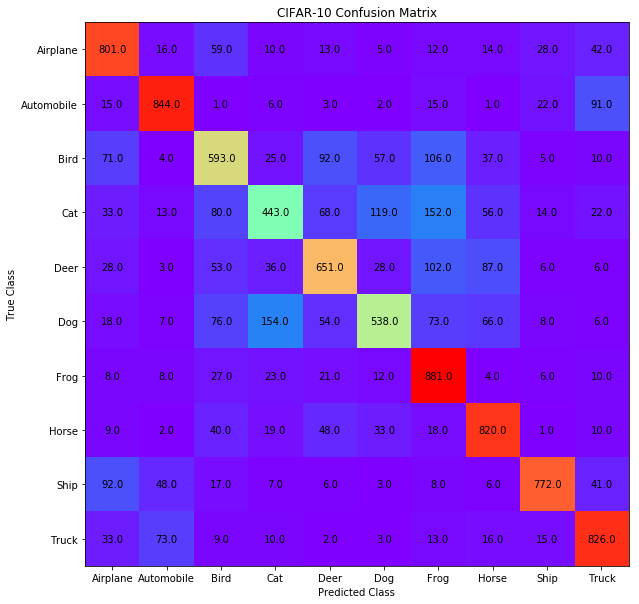

In [12]:
# Plot confusion matrix
fig = plt.figure(figsize=(10,10))
plt.tight_layout()
ax = fig.add_subplot(111)
res = ax.imshow(cmat, cmap=plt.cm.rainbow,interpolation='nearest')
width, height = cmat.shape
for x in xrange(width):
    for y in xrange(height):
        ax.annotate(str(cmat[x,y]), xy=(y, x),horizontalalignment='center',verticalalignment='center')

classes = ['Airplane','Automobile','Bird','Cat','Deer','Dog','Frog','Horse','Ship','Truck']
plt.xticks(range(width), classes, rotation=0)
plt.yticks(range(height), classes, rotation=0)
ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class')
plt.title('CIFAR-10 Confusion Matrix')
plt.show()